<a href="https://colab.research.google.com/github/uk7777/HeadCT-deface/blob/main/head-CT-de-identifciation-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics
!pip install pydicom
!pip install gdcm
!apt-get update
!apt-get install -y dcmtk
!pip install pydicom gdcm pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

In [3]:
# Install YOLOv8 and Pytorch for using YOLO

from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pydicom
from pydicom.uid import RLELossless
import cv2
# Load a model
model = YOLO('/content/best.pt')



In [4]:
# Get dcm files in a folder and return a list
import os
def get_file_list(input_path, extension) :
    try :
        list_path = []
        list_file = []
        list_full = []

        for (path, _, file) in os.walk(input_path):
            for each_file in file:
                if each_file.split('.')[-1] == extension:
                    list_path.append(path)
                    list_file.append(each_file)
                    list_full.append(os.path.join(os.getcwd(),path,each_file).replace('.\\',''))
        return list_full
    except :
        return 'get_file_list error.'

In [5]:
def dcm2jpg_array(array):
    return cv2.normalize(array, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)


In [21]:
def deface_features(dcm_list, result_path, result_png_path, features):
    #features
    # 0 : eye, 1 : nose, 2 : ear, 3 : mouth
    for dcm_path in dcm_list:
        folder = result_path+str(dcm_path.split('/')[-1].split('.')[0])
        folder_png = result_png_path+str(dcm_path.split('/')[-1].split('.')[0])
        file_name = str(dcm_path.split('/')[-1].split('.')[0])
        print(dcm_path, folder, folder_png, file_name)

        if not os.path.exists(folder):
            os.makedirs(folder)
        if not os.path.exists(folder_png):
            os.makedirs(folder_png)

        ds = pydicom.dcmread(dcm_path)
        array = ds.pixel_array
        array = dcm2jpg_array(array)
        array = Image.fromarray(array)
        x = np.array(array)
        results = model.predict(array, conf=0.5)
        for result in results:
            boxes = result.boxes.cpu().numpy()
            for box in boxes:
                if box.cls in features:
                    r = box.xyxy[0].astype(int)
                    x = cv2.rectangle(x, r[:2], r[2:], (0, 0, 0), -1)
        png = Image.fromarray(x)
        png.save(folder_png+'\\'+file_name+'.png')

        img_gray = x.astype("uint16") * 16
        arr = img_gray
        ds.compress(RLELossless, arr)
        ds.save_as(folder+'\\'+file_name+'.dcm')




In [24]:
dcmfile = './sample-head-CT.dcm'
deface_features([dcmfile], './output_dcm/', './output_png/', [0,1,2,3])

./sample-head-CT.dcm ./output_dcm/sample-head-CT ./output_png/sample-head-CT sample-head-CT

0: 640x640 1 nose, 1 ear, 4596.8ms
Speed: 7.7ms preprocess, 4596.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


## De-identification Process


0: 640x640 1 nose, 1 ear, 6131.7ms
Speed: 5.2ms preprocess, 6131.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


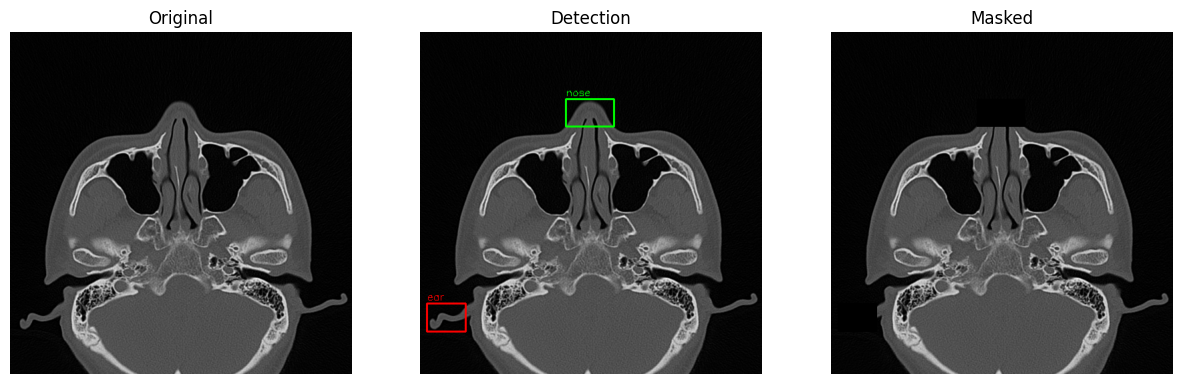

In [25]:
import cv2
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from PIL import Image


# 1. Read DICOM
ds = pydicom.dcmread(dcmfile)
image = ds.pixel_array
img_u8 = (image / image.max() * 255).astype(np.uint8)
orig = img_u8.copy()
draw = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)
masked = draw.copy()

# 2. YOLO model
results = model.predict(Image.fromarray(orig), conf=0.5)
label_map = {0: "eye", 1: "nose", 2: "ear", 3: "mouth"}
colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0)]

for r in results:
    boxes = r.boxes.cpu().numpy()
    for i in range(len(boxes)):
        cls_id = int(boxes.cls[i])
        x1,y1,x2,y2 = boxes.xyxy[i].astype(int)
        color = colors[cls_id % len(colors)]
        cv2.rectangle(draw, (x1,y1), (x2,y2), color, 2)
        cv2.putText(draw, label_map.get(cls_id,str(cls_id)), (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        cv2.rectangle(masked, (x1,y1), (x2,y2), (0,0,0), -1)

# 3. Output (Original → Detection → Masked)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(orig, cmap='gray'); plt.axis('off'); plt.title('Original')
plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title('Detection')
plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title('Masked')
plt.show()
